# Marine Hydrodynamics Assignment 3

## Introduciton
 NACA airfoils are airfoil shapes designed for aircraft wings. What is characteristic about them is that each number of the asigned code-name is a foils' parameter. When these values are entered in specific equaitons they produce the desired shape. A hydrodynamic analysis of the NACA-XXXX foil is undertaken and the foil's performance depends on 2 different parameters is analysed. A range of  camber to chord ratio ($m/c$) and the angle of attack ($\alpha$) values are tested. The top and bottom points of flow seperation are found for each case, and the added mass was estimated. The two methods of varrying the foil properties are compared and each one's benefits are outlined. Finally, the results are compared and an optimal $m/c$ ratio is determined.

## Method / Results
Boundary layer decomposition analysis  is used to analise the flow. Although Computaitonal Fluid Dynamics (CFD) methods are frequently used in the marine industry, they are often time consuming and costly.

The flow around any immersed body can be expresed by a curved vortex sheet that has variable strength $\gamma(s)$ and acts as an infinititely thin version of the boundary layer. On the body side, no-slip condition is enforced and on the flow side the slip velocity $u_s=-\gamma$. The vortex sheet wrapped around the surface is then split in to continoues  pannels which allows some simplifications to be made. Each panel is considered to have its own $\gamma_j$ strength which is constant throughout each panel. Thus, the induced panel velocity is expressed by $\vec u_j=\gamma_j\vec f_j(x,y)$, where $\vec f_j$ is the panel influence function and depends on the panel geometry. The velocity at any point is expressed as \begin{equation}
\vec u(x,y) = \vec U+\sum_{j=0}^{N-1} \vec u_j(x,y)
\end{equation}

where we use the index  $j$ to label each of the $N$ panels, $\vec U$ is the uniform flow and $\vec u_i$ is de velocity induced by panel i. 

By substiotuting both velocity equations, the no-slip boundary equation is converted into a linear algebraic condition: 
$$ u_s = \left[\vec U + \sum_{j=0}^{N-1} \gamma_j \ \vec f_j(x,y)\right]\cdot\hat s=0 $$

From the graphs below, lift increases linearly with camber and angle of attack and $C_L$ values range from 0-2.8. On the other hand, $C_D$ values have a wider range 0-3.2. Drag does not scale linearly for $2\le m/c\le 9\%$ and $2\le \alpha\le 7$.
Although angle of attack $\alpha$ and camber $m/c$ selection greatly depend on design requirments, it is expected that the highest lift whilst keeping drag to a minimum is the desirable outcome.
On this bases, the most efficient parameters that provide $C_L/C_D=1.6\%$ are $\alpha =10$ and $m/c=0\%$. 

However, the overall performance can not be determined solely by this criterion as the foil might still produce high drag even if it still will be proportionally smaller than lift. Baced on this,the wider range of $7\le \alpha\le 10$ and $0\le m/c\le 4\%$ are considered best options to pick from as $C_L/C_D \ge 1$


In [70]:
#Annoying folder stuff
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Import plotting and numpy
import math as m
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

# Import vortex panel and boundary layer functions
from vortexpanel import VortexPanel as vp
from vortexpanel import BoundaryLayer as bl

# Generation of a 2D cambered foil
A 4 digit equation driven NACA foil was as the foil for unvestigation. This was done due to the ease of varying the foils properties. The shape of the foil is described as follows, 
* The first digit is divided by 100 to obtain the maximum camber m as a fraction of the chord ___c___
* The second digit is divided by 10 to obtain the location of the maximum camber ___p___ as a fraction of the chord ___c___
* The final 2 digits are divided by 100 to obtain the foils thickness ___t___ as a fraction of the chord ___c___

This allowed a series of foils with a with a camber in the range $0\le m/c\le 10\%$ to be generated. To facilitate the compararion of these foils, a chord of 1 and a $t/c=0.15$ was used.

The x and y co-ordinates of the foil are calculated for $N$ points.

The neccessary value for $N$ is determined by measuring the distance around the foil, and solving for $\gamma$.

In [71]:
#https://en.wikipedia.org/wiki/NACA_airfoil#Equation_for_a_cambered_4-digit_NACA_airfoil
t = 0.15; c = 1; p = 0.3;

def camber_line( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    m * (x / np.power(p,2)) * (1 / c) * (2.0 * p - (x / c)),
                    m * ((c - x) / np.power(1-p,2)) * (1.0 + (x / c) - 2.0 * p ))

def dyc_over_dx( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    ((2.0 * m) / np.power(p,2)) * (p - (x / c)),
                    ((2.0 * m ) / np.power(1-p,2)) * (p - (x / c )))

def thickness( x, t, c ):
    term1 =  0.2969 * (np.sqrt(x/c))
    term2 = -0.1260 * (x/c)
    term3 = -0.3516 * np.power(x/c,2)
    term4 =  0.2843 * np.power(x/c,3)
    term5 = -0.1015 * np.power(x/c,4)
    return 5 * t * c * (term1 + term2 + term3 + term4 + term5)

#max camber, location of max camber, thickness, chord 

def naca4(N, m, p=0.3, t=0.15, c=1):
    x = np. linspace(0, c, N)
    dyc_dx = dyc_over_dx(x, m, p, c)
    th = np.arctan(dyc_dx)
    yt = thickness(x, t, c)
    yc = camber_line(x, m, p, c)
    x_top, y_top = (x - yt*np.sin(th), yc + yt*np.cos(th))
    x_bot, y_bot = (x + yt*np.sin(th), yc - yt*np.cos(th))
    xbot = np.flip(x_bot)
    ybot = np.flip(y_bot)
    xcoord = np.concatenate([xbot[:-1], x_top])
    ycoord = np.concatenate([ybot[:-1], y_top])
    return xcoord, ycoord


# Obtaining the Panel Array and Solving for flow around the foil
This section of code takes the x and y array for the foil and returns a panel array of the foil coordinates. Following this, the flow is solved for $\gamma$ when the foil is at angle $\alpha$ to the flow.

In [72]:
#solve for pannels
def make_naca4(N, m, **kwargs):
    x, y = naca4(N, m, **kwargs)
    panels = vp.panelize(x, y)
    return panels

def plot_naca4(N, m, alpha):
    plot = make_naca4(N, m)
    plot.solve_gamma_O2(alpha , kutta = [(0,-1)]) 
    plot.plot_flow()
      
    plt.xlim(-0.05, 1.05);
    plt.ylim(-0.5, 1.05);
    


# Obtaining Results
Once the NACA foil is fully defined, the `make_naca4` function is called to generate the panel array across a range of $m$ values. This is used for further analysis to calculate coefficients of lift and drag, as well as the added mass tensor

## Convergence 

To check that convergance has been reached, the distance around the foil is measured using the `distance` function imported from `VortexPanel`. The code solves for $\gamma$ for $N = 2^n$ where $2 \leq n \leq 9$. 

The Figure below shows that the system converges when N is equal to 128.

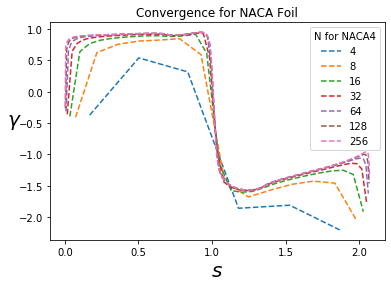

In [73]:
#validating Convergence of the system

# Loop over resolutions
for N in 2**np.arange(2,9,1):         # N in powers of 2
    naca = make_naca4(N, m=0.05)         # define geometry abitary value of m used
    s = naca.distance()              # get distance array
    
    naca.solve_gamma(alpha = 0.05, kutta = [(0, 1)])    # solve for gamma, abitary value of alpha used
    gamma = naca.get_array('gamma')   # get gamma array
    plt.plot(s,gamma,'--',label=N)      # plot

# plot to determine convergence
plt.legend(title='N for NACA4')
plt.xlabel(r'$s$', fontsize=20)
plt.ylabel(r'$\gamma$', fontsize=20, rotation=0)
plt.title('Convergence for NACA Foil')
plt.show()

#convergence around 64/128

# Verification of Kutta Condition application

To further verify the model used, the first and last value of $\gamma$ is compared. When $\gamma[0] = -\gamma[-1]$, the kutta conditon has been correctly applied. This occurs when $N=256$ when compared at 3 significant figures, however it occurs at 64 for 2 significnat figures. From this, it can be conclused that the kutta condition has been correctly applied to the system.

In [74]:
for N in 2**np.arange(3,10,1):
    naca = make_naca4(N, m=0.05)
    naca.solve_gamma(alpha=0.05, kutta = [(0, -1)])
    gamma = naca.get_array('gamma')
    print(r'N: {:.0f}, Diff. in vortex strengths: {:.4f}'.format(N, gamma[0] + gamma[-1]))

N: 8, Diff. in vortex strengths: 0.0084
N: 16, Diff. in vortex strengths: 0.0047
N: 32, Diff. in vortex strengths: 0.0026
N: 64, Diff. in vortex strengths: 0.0014
N: 128, Diff. in vortex strengths: 0.0008
N: 256, Diff. in vortex strengths: 0.0004
N: 512, Diff. in vortex strengths: 0.0002


# Coefficient of Lift $C_L$

To compute the pressure, $P$, we can use the Bernoulli equation

$$ P+\frac {1}{2} \rho\ |u|^2-\rho gz = B $$

where $\rho$ is the density, $\rho gz$ is the head, and $B$ is the Bernoulli coefficient. As in the rest of this course, will assume no hydrostatic pressure.

To avoid the ambiguity of the Bernoulli coefficient, we typically work with the pressure coefficient $c_p$

$$c_p = \frac{P-P_\infty}{\frac{1}{2} \rho U^2}$$
instead of the pressure.

Once we have the surface pressure we can use it to determine the pressure force on the body, as

$$ \vec F_p = -\oint p \hat n da $$

where $\oint da$ is the integral over the body surface, and $\hat n$ is the normal vector to the surface. 

For instance, the lift coefficient is then:

$$ C_L = \frac{\vec F_p \cdot \hat U_\perp} { \tfrac 12 \rho U^2 A }  = \frac{-\oint p \hat n \cdot \hat U_\perp ds }{ \tfrac 12 \rho U^2 c } c= -\frac{\oint c_p (s_x\cos\alpha+s_y\sin\alpha) ds}{ c } $$

where $c$ is the coord, $\hat U_\perp=\cos\alpha\hat y-\sin\alpha\hat x$ is the direction perpendicular to the free stream and $\hat n=s_x\hat y-s_y\hat x$.

And we can use $|u/U|^2=\tilde\gamma^2=\gamma^2$ on the body of $N$ panels to give

$$ C_L = \Sigma_N [(1-\gamma^2) S_N \hat n_N] / c $$


In [75]:
@np.vectorize
def C_L(panels,alpha):
    """ Calculate the coefficient of lift for a solved Panel Array

    Inputs:
    panels    -- a solved Panel Array
    alpha     -- the angle of attack

    Outputs:
    The coefficient of lift

    Example:
    alpha=np.radians(10)                                # set the angle of attack
    ellipse = vp.make_ellipse(N=32,t_c=0.5)             # make a 1:2 elliptical Panel array
    ellipse.solve_gamma_O2(alpha=alpha)                 # solve the ellipse flow using a second order panel array method
    print(C_L(ellipse, alpha=alpha))                    # print the coefficient of lift
    """
    gamma, xc, S, sx, sy = panels.get_array('gamma','xc','S','sx','sy') # use the solved flow to retrieve gamma, xc, S, sx, sy
    c = max(xc)-min(xc)                                                 # calculate the length of the foil chord
    perp = sx*np.cos(alpha)+sy*np.sin(alpha)                            # calculate the normal 
    return -sum((1-gamma**2)*2*S*perp)/c                                # return the coefficient of lift (summation of c_p x normal over the surface)

## Validation of $C_L$ function

There exists an analytical solution for $C_L$ of a Joukowski foil

$$C_L = 2\pi \left(1+\frac {4}{3\sqrt 3} \frac {t}{c} \right)\sin\alpha$$

where $t/c$ is the thickness to coord ratio.

Writing this into a simple function for testing

In [76]:
def analytic_C_L(alpha,t_c=0.2355): # t/c of jfoil xcen=-0.1
    """ Calculate the analytic coefficient of lift for a Joukowski foil

    Inputs:
    alpha     -- the angle of attack
    t_c       -- the thickness of the foil as a fraction of chord

    Outputs:
    The analytic coefficient of lift

    Example:
    print(analytic_C_L(alpha=0.1, t_c=0.2355))
    """
    return 2*np.pi*(1+t_c*4/(3*np.sqrt(3)))*np.sin(alpha)

Testing this on a Joukowski foil with centre (-0.1, 0) and thus $t/c = 0.2355$ leads to:

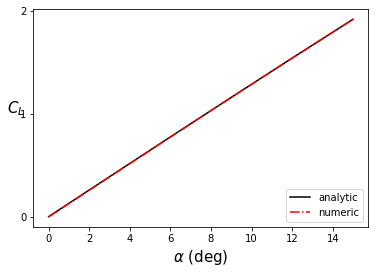

In [77]:
alpha_deg = np.linspace(0,15,6)
alpha = alpha_deg*np.pi/180.
plt.plot(alpha_deg,analytic_C_L(alpha), 'k', label='analytic')

jfoil = vp.make_jfoil(N=128, xcen=-0.1, ycen=0)
lift = []
for a in alpha:
    jfoil.solve_gamma_O2(a, kutta=[(0, -1)])
    lift.append(C_L(jfoil, a))
plt.plot(alpha_deg, lift, 'r-.', label='numeric')

plt.legend(loc='lower right')
plt.xlabel(r'$\alpha$ (deg)', fontsize=15)
plt.ylabel(r'$C_L$', fontsize=15, rotation=0)
plt.yticks([0,1,2]);

From this figure it can be seen that there is no noticable difference between the analytical and numerical solution between the analytical and numerical solutions.

# Coefficient of Drag $C_D$

Because potential flow has no pressure drag. D'Alemberts paradox states that any 'closed' flow can't give any pressure drag. Therefore we must define a wake model to measure drag

## Assumptions

* The boundary layers separate from the body into a pair of **shear layers**, 
* The shear layers maintain the same strength ($\gamma$) as they were at the point of separation. 
* The distance between the shear layers ($w$) stays the same.

The vortex impulse drag for this model is:

$$D_P = \rho \frac{d}{dt} \int_S y \gamma ds$$

given the above assumptions we have

$$ y = \pm \frac{w}{2} \text{ and } \gamma = \pm\gamma_{wake} $$

Since the wake sheets are formed from the sperating of boundary layers, the wake strength should match the potential flow solution at the point of separation

$$ \gamma_{wake} \approx u_e|_{sep} $$

and by the same argument, 

$$ \frac{d}{dt}S \text{~} u_e|_{sep} \approx \gamma_{wake}$$

since $y = +/- 0.5w$ and $ds/dt \approx \gamma$, we have

$$D_P \tilde{} \rho \gamma^2 A_w$$

where $A_w = wh$ is the wake width

$$C_D = \frac{D}{0.5 \rho U^2 A_F} \propto \frac{A_w \gamma^2}{A_F U^2} \equiv A_\gamma$$

Therefore we define a wake drag coefficient as:

$$C_\gamma = \frac{wb}{A_F} \tilde{u}^2_e|_{sep} = \frac {\rho \gamma^2 w}{\rho U^2 t} = \frac w t \tilde\gamma ^2 \propto C_P$$ 

Since the wake coefficient $C_\gamma$ only scales like the drag coeffient $C_D$ we must calibrate our wake drag coefficient $C_\gamma$ to scale with $C_D$ using empirical data from Hoerner for an ellipse at 0 angle of attack:

```
c_t = [1.27,1.67,2.06,3.06,3.39,4.03,4.73,8.15]
CD = [0.919,0.718,0.604,0.438,0.408,0.342,0.324,0.267]
```

where `c_t` is the $c/t$ value of the ellipse, and `CD` is the $C_D$ value measure in the experiments

In [78]:
def C_gamma(panels):
    """ Calculate the wake coefficient for a solved Panel Array

    Inputs:
    panels    -- a solved Panel Array

    Outputs:
    The wake coefficient

    Example:
    panels = vp.make_ellipse(N, t_c)    # create a PanelArray object for an ellipse
    panels.solve_gamma_O2()             # solve the flow
    print(C_gamma(panels))              # print the value of C_gamma
    """
    top,bot=panels.split()                              # split the panels at the stagnation point
    _,_,iSep = top.thwaites()                           # locate the separation point along the top of the shape
    gamma_top = bl.sep(top.get_array('gamma'),iSep)     # get the value of gamma at the separation point
    w_top = bl.sep(top.get_array('yc'),iSep)            # get the y-value (measured perpendicularly from the chord) at the separation point (w)
    y = panels.get_array('yc')                          # get the y-values of the panel array
    thickness = max(y)-min(y)                           # calculate the height of the shape (t)
    return (2*w_top*gamma_top**2)/thickness             # calcualte the wake coefficient

Calibrating the function using `numpy.polyfit` and `numpy.poly1D` to fit a first-order line through the points, forcing an point at the origin since $C_\gamma \propto C_D$ we know that when $C_D = 0$, $C_\gamma$ will also equal $0$:

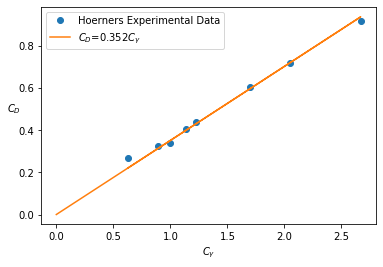

In [79]:
# Hoerner's data
c_t = np.array([1.27,1.67,2.06,3.06,3.39,4.03,4.73,8.15])
CD = [0.919,0.718,0.604,0.438,0.408,0.342,0.324,0.267]

@np.vectorize
def ellipse_c_gamma(t_c, N=128):
    """ Calculate the wake coefficient for an ellipse aligned with the flow (alpha=0)

    Inputs:
    t_c    -- the ellipse thickness/chord value
    N      -- the number of panels to create the ellipse with

    Outputs:
    The wake coefficient

    Example:
    print(ellipse_c_gamma(0.5, N=64))
    """
    panels = vp.make_ellipse(N, t_c)    # create a PanelArray object for an ellipse
    panels.solve_gamma_O2()             # solve the flow
    return C_gamma(panels)              # return the value of C_gamma

plt.plot(ellipse_c_gamma(1/c_t), CD, 'o', label=r'Hoerners Experimental Data')  # plot the wake ceofficient against the experimental data

x = np.append(np.array([0]), ellipse_c_gamma(1/c_t), axis=0)    # setup the data with a point at the origin
y = np.append(np.array([0]), CD, axis=0)
weights= np.append(np.array([10**10]), np.ones_like(CD))        # weight the point at the origin high to force the regression through that point
best_fit=np.polyfit(x, y, 1, w=weights)                         # regress the weighted data
plt.plot(x, np.poly1d(best_fit)(x), label=r'$C_D$={:.3f}$C_\gamma$'.format(best_fit[0]))    # plot the data

plt.xlabel(r'$C_\gamma$')
plt.ylabel(r'$C_D$', rotation=0)
plt.legend()
plt.show();

This figure clearly shows that the numerical results fit well with the trend presented in the experimental data, and that a the ratio between the drag and wake coefficients is $1:0.350 (C_D:C_\gamma)$.

In [80]:
def C_D(panels, coeff=0.350):
    """ Calculate the drag coefficient for a solved panel array

    Inputs:
    panels    -- a solved panel array
    coeff     -- the first order coefficient relating C_gamma to C_D

    Outputs:
    The drag coefficient

    Example:
    panels = vp.make_ellipse(N, t_c)    # create a PanelArray object for an ellipse
    panels.solve_gamma_O2()             # solve the flow
    print(C_D(panels))                  # print the value of C_gamma
    """
    wake_drag = C_gamma(panels)
    return coeff*wake_drag

# Added mass coefficients $m_{11}$, $m_{12}, m_{22}, m_{66}$

The force on a body in an ideal fluid is:

$$ \vec{F} = - \oint P \hat{n} ds $$

For 1D linear motion, the scale potential into the unsteady Bernoulli equation gives the pressure in a flow as

$$ P = P_\infty - \rho a_x \tilde{\phi}_x - \frac{1}{2} \rho U_x^2 |\nabla \tilde{\phi}_x |^2 $$

where $a_x = \frac{dU_x}{dt}$ is the bodys acceleration. Substuting into the first equation gives:

$$ \vec{F} = a_{x} \rho\oint \tilde{\phi} \hat{n} dx + \frac{1}{2} \rho U^2 \oint |\nabla \tilde{\phi}|^2 ds $$

where the first expression in the equation

$$ a_{xx} P_c \oint \tilde{\phi} \hat{n} dx $$

is the additional force $F_a$ due to added mass and the latter is the lift and drag forces.

The added mass coefficient $m_{ij}$ can then be defined as

$$ m_{j,i} = \rho \int_s \phi_j n_i dS \approx \rho \sum_{m=1}^N [\phi_j]_m [n_i]_m \Delta S_m $$

For a body made from vortex panels in uniform flow, superposition gives that

$$ -\pi \phi_n + \sum_{m=1}^N \int_S \frac{\partial}{\partial n} logrdS = \sum_{m=1}^N [\frac{\partial \phi}{\partial n}]_i h_{n,m} \text{ where } n \epsilon 1, 2, ...,N $$ 

Where

$$\frac{\partial \phi_i}{\partial n} = n_i$$

$$ h_{n,m} = \int_{S_m} logrdS $$

This allows us to discretise the equations into smaller elements $S_N$ using the following approximation

$$ h_{n,m} \approx \frac{1}{2} [log( (x_m^{(1)}-\bar{x}_n)^2)^2 + (y_m^{(1)}-\bar{y}_n)^2)^2 ) + log( (x_m^{(2)}-\bar{x}_n)^2)^2 + (y_m^{(2)}-\bar{y}_n)^2)^2 )](\frac{1}{2} \Delta S_m) $$

where $x_m$ and $y_m$ are the x and y coordinates of the start $^{(1)}$ and end  $^{(2)}$ of the panel, and $\bar{x}_n$ and $\bar{m}_n$ are the coordinates of the centers of the panel.

The unit vectors can be calculated as

$$ n_1 = -\frac{dy}{dS} = -s_y $$

$$ n_2 = \frac{dx}{dS} = s_x $$

and 

$$ n_6 = \mathrm{r} \times \mathrm{n} = xn_2 -yn_1 $$

The flux integral $\int_{S_m} (\frac{\partial}{\partial n})logrddS$ is equal to the negative of the panels opening angle $-\delta \theta_{n,m}$ of segment $S_m$, so therefore we can write the discretised equation

$$ -\pi \phi_n + \sum_{m=1}^N \phi_m (\Delta \theta_{n,m}) = \sum_{m=1}^N [\frac{\partial \phi}{\partial n}]_i h_{n,m} \text{ where } n \epsilon 1, 2, ...,N $$ 

the above equation can be expressed as 

$$ A \phi = B $$

where $A$ is a matrix of all opening angles on the equations left hand side, and $B$ is equal to the right hand side of the equation. Matrix $A$ can be filled out using basic trigonometry. The solution for potential $\phi$ can then be used to find the added mass coefficients through the equation

$$ m_{j,i} = \rho \int_S \phi_j n_i dS \approx \rho \sum_{m=1}^N [\phi_j]_m [n_i]_m \Delta S_m $$

The added mass tensor is symmetric

$$ m_{12} = m_{21} $$

this can be confirmed through Green's theorem 

$$ \int \int_S [\phi \frac{\partial \psi}{\partial n} = \psi \frac{\partial \phi}{\partial n}]dS = \int \int_V \int \nabla \cdot (\phi \nabla \psi - \psi \nabla \phi) dV = 0 $$

Applying this to potentials $\phi_i$ and $\phi_j$ over a closed surface $S_B + S_C$ reveals that $S_C$ vanishes as $r \rightarrow \infty$, and so

$$ \int \int_S{S_B} [\phi_j \frac{\partial \phi_i}{\partial n} \phi_i \frac{\partial \phi_j}{\partial n}]dS = 0 $$

and 

$$ m_{i,j} = m_{j,i} $$

allowing us to neglect reporting both $m_12$ and $m_21$ from the function.

This "added mass" theory section was written with reference to Farnaz Rezvany's work, available at: `https://github.com/frh-uio/MEK4420/tree/master/MandatoryAssignment1` and (Newman, J.N. 2017, **Marine Hydrodynamics**, The Massachusetts Institute of Technology, United States of America). The added mass code below was based upon the code found under in this repository.

Modifications made:

* Input edited to accept a `PanelArray` object could be passed into the the function. 

* Utilised `PanelArray.get_array()` to simplify the calculations of normals and to calculate the start and and points of each panel.

* Function now returns $m_{12}$

* Function raises a `ValueError` is the matrix is not symmetric ($m_{12} - m_{21} > 10^{-3}$)

In [81]:
def added_mass(panels):
    """ Calculate the added mass of a PanelArray object

    Inputs:
    panels    -- a panel array

    Outputs:
    m11, m22, m66

    Example:
    panels = vp.make_ellipse(N, t_c)         # create a PanelArray object for an ellipse
    m11, m22, m66 = added_mass(panels)       # solve the flow
    print(m11, m22, m66)                     # print the value of C_gamma
    """
    xc, yc, S, sx, sy = panels.get_array('xc','yc','S','sx','sy') # Retrieve gamma, xc, S, sx, sy
    N = len(panels.panels)  # Get number of panels used
    A = np.zeros((N, N))    # For storage of the values from the lhs of the equation
    B11 = np.zeros(N)       # Arrays for storage of values for  the rhs of the equation
    B22 = np.zeros(N)
    B66 = np.zeros(N)

    dS = 2*S                # length of panel
    n1 = -sy                # normal in the x direction
    n2 = sx                 # normal in the y direction
    n6 = xc * n2 -yc * n1   # from cross product

    x = np.empty(N+1)
    x[0] = xc[0] - S[0]*sx[0]
    x[1:] = xc + S*sx

    y = np.empty(N+1)
    y[0] = yc[0] - S[0]*sx[0]
    y[1:] = yc + S*sy

    for i in range(N):
        r1 = np.linalg.norm(np.array([x[:-1], y[:-1]]).T - np.array([xc[i], yc[i]]), axis=1)
        r2 = np.linalg.norm(np.array([x[1:], y[1:]]).T - np.array([xc[i], yc[i]]), axis=1)

        theta = -np.arccos( (dS**2 - r2**2 - r1**2)/(-2*r2*r1) )
        theta[np.isnan(theta)] = 0

        h11 = (np.log(r1) + np.log(r2))*0.5*dS
        h22 = (np.log(r1) + np.log(r2))*0.5*dS
        h66 = (np.log(r1) + np.log(r2))*0.5*dS

        A[i] = theta
        np.fill_diagonal(A, -np.pi)

        B11[i] = sum(n1*h11)
        B22[i] = sum(n2*h22)
        B66[i] = sum(n6*h66)

    phi11 = np.linalg.solve(A, B11)
    phi22 = np.linalg.solve(A, B22)
    phi66 = np.linalg.solve(A, B66)

    m11 = sum(phi11*n1*dS)
    m12 = sum(phi11*n2*dS)
    m21 = sum(phi22*n1*dS)
    m22 = sum(phi22*n2*dS)
    m66 = sum(phi66*n6*dS)
    if m12-m21 > 5*(10**-3):
        raise ValueError("Added mass matrix is not symmetric")

    return m11, m12, m22, m66


## Verification of added mass code

An analytical solution exists for an ellipse aligned with flow, with length $a$ in the direction of flow, and length $b$

$$ m_{11} = \pi \rho b^2 $$
$$ m_{22} = \pi \rho a^2 $$
$$ m_{12} = 0 \text{, true for any symettrical shape} $$
$$ m_{66} = \frac{1}{8} \pi \rho (a^2 - b^2)^2 $$

In these non-dimenional simulations, $\rho$ can be taken to be effectively 1 for the purposes of comparison, and $b/a = t/c$

For a foil of thickness 15% (t/c=0.15):
Analytical solution: m11 = 0.07069, m12 = 0.00000, m22 = 3.14159, m66 = 0.37523
Numerical  solution: m11 = 0.07031, m12 = 0.00012, m22 = 3.10827, m66 = 0.37061
Error (%):           m11 = -0.5370, m12 = inf, m22 = -1.0606, m66 = -1.2302



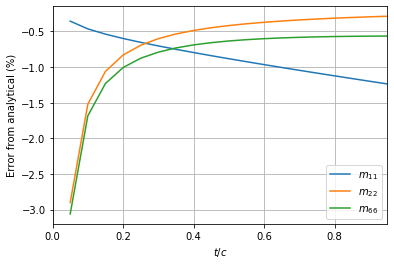

In [82]:
@np.vectorize
def ellipse_added_mass(N, t_c):
    """ Calculate the analytical and numerical added masses, as well as the error between them

    Inputs:
    N       -- the number of panels to use
    t_c     -- the thickness of the ellipse (as a multiple of chord)

    Outputs:
    (m11, m22, m66) for analytical and numerical methods, then percentage error of the numerical results

    Example:
    m11_exact, m22_exact, m66_exact, m11, m22, m66, m11_error, m22_error, m66_error = ellipse_added_mass(N=500, t_c=0.5)   # Results from function
    print(m11_analytical)                                               # print the value of m11 as
    """
    ellipse = vp.make_ellipse(N, t_c)

    m11_exact = np.pi*t_c**2
    m22_exact = np.pi
    m12_exact = 0
    m66_exact = 1/8 * np.pi * (1 - t_c**2)**2
    
    m11, m12, m22, m66 = added_mass(ellipse) 

    m11_error = (m11/m11_exact-1)*100
    m12_error = (m12/m12_exact-1)*100
    m22_error = (m22/m22_exact-1)*100
    m66_error = (m66/m66_exact-1)*100

    return m11_exact, m12_exact, m22_exact, m66_exact, m11, m12, m22, m66, m11_error, m12_error, m22_error, m66_error

N=500

m11_exact, m12_exact, m22_exact, m66_exact, m11, m12, m22, m66, m11_error, m12_error, m22_error, m66_error = ellipse_added_mass(N, 0.15)
print('For a foil of thickness 15% (t/c=0.15):')
print('Analytical solution: m11 = {:.5f}, m12 = {:.5f}, m22 = {:.5f}, m66 = {:.5f}'.format(m11_exact, m12_exact, m22_exact, m66_exact))
print('Numerical  solution: m11 = {:.5f}, m12 = {:.5f}, m22 = {:.5f}, m66 = {:.5f}'.format(m11, m12, m22, m66))
print('Error (%):           m11 = {:.4f}, m12 = {:.4f}, m22 = {:.4f}, m66 = {:.4f}'.format(m11_error, m12_error, m22_error, m66_error))
print()

t_c = np.arange(0.05, 1, 0.05)
_, _, _, _, _, _, _, _, m11_error, m12_error, m22_error, m66_error = ellipse_added_mass(N, t_c)
plt.plot(t_c, m11_error, label='$m_{11}$')
plt.plot(t_c, m22_error, label='$m_{22}$')
plt.plot(t_c, m66_error, label='$m_{66}$')
plt.xlabel(r'$t/c$')
plt.ylabel(r'Error from analytical (%)')
plt.xlim(0, max(t_c))
plt.grid('both')
plt.legend()
plt.show()

From the above calculations and graph, it can be seen that the `added_mass` function returns values close to the analytical solutions, and should be expected to give results with approximately 1% error with foils of thickness 15%. 

# Separation Point

Utilising Thwaites integral

$$ \frac{\delta_2}{L} (Re_L)^2 = ( \frac{0.45}{u_s^6(s)}  \int_0^s{u_s^5(s)ds})^{0.5} $$

we can use algebra to give

$$ \frac{du_s}{ds}\frac{\delta_2^2 U}{\nu L} = \frac{du_e}{dx}\frac{\delta_2^2}{\nu} = \lambda c_2^2 = f(\lambda) $$

where the left hand side is known from Thwaites and the prescribed $u_s$ array, and $c_2=\delta_2/\delta$ which is a known function of $\lambda$. Therefore, we can determine $\lambda$ on every point along the body and locate the point at which the flow separated, where $\lambda=-12$.

In [83]:
def sep_point(panels):
    """ Calculate separation points on a solved PanelArray

    Inputs:
    panels  -- a solved PanelArray object

    Outputs:
    (m11, m22, m66) for analytical and numerical methods, then percentage error of the numerical results

    Example:
    ellipse = vp.make_ellipse(64, 0.5)  # make ellipse
    ellipse.solve_gamma_O2(alpha=0.1)   # solve flow
    ellipse.plot_flow()                 # plot flow
    xs, ys = sep_point(ellipse)         # get separation points
    plt.scatter(xs, ys, s=100, c='g', zorder=10)    # plot separation points ontop of flow
    """
    top, bot = panels.split()   # split the body at the stagnation points
    _,_,itop = top.thwaites()   # get the seperation points distance allong array
    _,_,ibot = bot.thwaites()

    top_x = top.get_array('xc')
    top_y = top.get_array('yc')
    bot_x = bot.get_array('xc')
    bot_y = bot.get_array('yc')

    top_xc = (top_x - min(top_x)) / (max(top_x) - min(top_x))
    top_yc = (top_y - min(top_y)) / (max(top_y) - min(top_y))
    bot_xc = (bot_x - min(bot_x)) / (max(bot_x) - min(bot_x))
    bot_yc = (bot_y - min(bot_y)) / (max(bot_y) - min(bot_y))

    x_top = bl.sep(top_xc, itop)   # get the x and y coordinates of the separation points
    y_top = bl.sep(top_yc, itop)
    x_bot = bl.sep(bot_xc, ibot)
    y_bot = bl.sep(bot_yc, ibot)
    return x_top, x_bot, y_top, y_bot


## Validation of Separation Point

Experimental data on the separation point on an ellipse, found by Hoerner, can be used to validate the separation code.

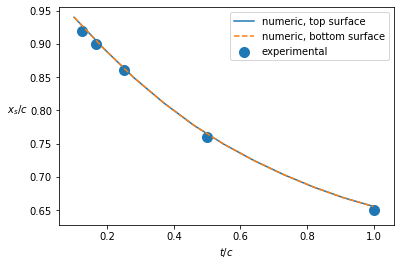

In [84]:
@np.vectorize
def ellipse_sep(t_c, N=128):
    """ Calculate separation points on an ellipse aligned with the flow

    Inputs:
    t_c     -- the thickness:length ratio of the ellipse
    N       -- the number of panels to construct the ellipse from

    Outputs:
    xs, ys  -- two lists containing the x and y coordinates of the separation points

    Example:
    """
    ellipse=vp.make_ellipse(N, t_c)
    ellipse.solve_gamma_O2()           
    return sep_point(ellipse) 

t_c = np.linspace(0.1,1,11)
xs_top = []
xs_bot = []
for i in t_c:
    x_top, x_bot, _, _ = ellipse_sep(i, N=128)
    xs_top.append(x_top)
    xs_bot.append(x_bot)
plt.plot(t_c,xs_top, label='numeric, top surface')
plt.plot(t_c,xs_bot, '--', label='numeric, bottom surface')
plt.scatter([1,1./2.,1./4.,1./6.,1./8.],
            [0.65,0.76,0.86,0.90,0.92],
            s=100, label='experimental')
plt.legend()
plt.xlabel(r'$t/c$')
plt.ylabel(r'$x_s/c$', rotation=0, labelpad=12);

The numerical predictions of separation point can be seen to fit well with the experimental separation points found by Hoerner.

# Parametric Study into foil camber

Studing performance metrics $C_L$, $C_D$ and the location of the separation points over the range $0 \leq m/c \leq 10\%$
The cord is kept constant,thus each change in $m/c$ to be expresed as only a change in camber. Angle of attack was kept constant to maintaine the same geometry for an accurate comparison of results.

In [114]:
def test_naca4(m_c, alpha, N=128):
    """Evaluate Drag coef.,Wake coeff., sepperation points for a set m/c
    Inputs: 
    m_c      --list of camber to cord ratios
    alpha    --angle of attack
    N        --number of panels
    Outputs:
    CL, CD, sep_coords, --Wake, Drag, top and bottom seperation coordinates
    """
    foil = make_naca4(N=N, m=m_c)
    foil.solve_gamma_O2(alpha, kutta=[(0,-1)])
    # CL = C_L(foil, alpha)
    # CD = C_D(foil)
    # sep_coords = sep_point(foil)
    return C_L(foil, alpha), C_D(foil), sep_point(foil)

#Create list of results
def camber_effects(alpha, m_c):
    """Evaluate Drag coef.,Wake coef., sepperation points for a range of m/c
    Inputs: 
    alpha [int]         -- the angle at which to evaluate
    m_c [array]         -- list of cambers at which to evaluate flow
    
    Outputs:
    CL,CD, sep_coords,  --Wake, Drag, top and bottom seperation coordinates
    """
    #Define lists for results 
    CL_list = []           
    CD_list = []
    sep_list = []
    added_mass_list = []

    for camber in m_c:
        CL, CD, sep = test_naca4(camber, alpha)
        CL_list.append(CL)                                                                       
        CD_list.append(CD) 
        sep_list.append(sep)
    return CL_list, CD_list, sep_list

def parametric_study(alpha, m_c):
    """Evaluate Drag coef.,Wake coef., sepperation points for a range of alpha and m/c
    Inputs: 
    alpha [array]       -- list of alphas at which to evaluate flow
    m_c [array]         -- list of cambers at which to evaluate flow
    
    Outputs:
    CL, CD, sep_coords,  --Wake, Drag, top and bottom seperation coordinates
    """
    CL_list = []           
    CD_list = []
    sep_list = []
    added_mass_list = []

    for alpha in alpha:
        CLs, CDs, seps = camber_effects(alpha, m_c)
        CL_list.append(CLs)                                                                       
        CD_list.append(CDs)
        sep_list.append(seps)
    return CL_list, CD_list, sep_list

In [115]:
m_c = np.arange(0, 0.11, 0.01)
alpha = np.deg2rad( np.arange(0, 11, 1) )

CL_list, CD_list, sep_list = parametric_study(alpha, m_c)

From the graph bellow, the Drag and Lift Coeffecients for each camber are displayed. For values bellow $m/c=\ 5\%$ the Lift is higher than drag. At the middle of the range examined, $C_D=C_L$ and for higher $m/c$ ratios drag is higher. Although there is not a "currect" value and based on design requirments the preferable lift to drag ration is what determines the most suitable ratio, for a foil that requires minimum input to maintain stability the $m/c=\ 5\%$ is proposed.

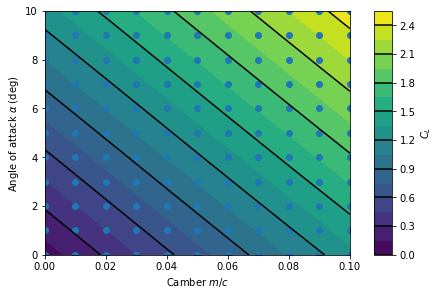

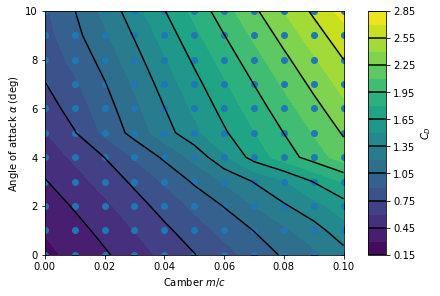

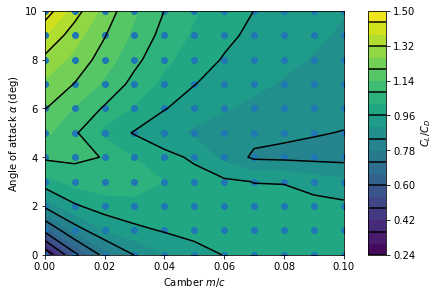

In [116]:
test_locs_x = np.array([m_c for i in alpha]).T
test_locs_y= np.rad2deg([alpha for i in m_c])


fig1, ax2 = plt.subplots(constrained_layout=True)
contour_plot = ax2.contourf(m_c, np.rad2deg(alpha), CL_list, 20)
ax2.set_xlabel(r'Camber $m/c$')
ax2.set_ylabel(r'Angle of attack $\alpha$ (deg)')
contour_plot2 = ax2.contour(contour_plot, levels=contour_plot.levels[::2], colors='k', origin='lower')
cbar = fig1.colorbar(contour_plot)
cbar.ax.set_ylabel(r'$C_L$')
cbar.add_lines(contour_plot2)
plt.scatter(test_locs_x, test_locs_y)
ax2.set_xlim(0, max(m_c))
ax2.set_ylim(0, np.rad2deg(max(alpha)))
plt.show()

fig1, ax2 = plt.subplots(constrained_layout=True)
contour_plot = ax2.contourf(m_c, np.rad2deg(alpha), CD_list, 20)
ax2.set_xlabel(r'Camber $m/c$')
ax2.set_ylabel(r'Angle of attack $\alpha$ (deg)')
contour_plot2 = ax2.contour(contour_plot, levels=contour_plot.levels[::2], colors='k', origin='lower')
cbar = fig1.colorbar(contour_plot)
cbar.ax.set_ylabel(r'$C_D$')
cbar.add_lines(contour_plot2)
plt.scatter(test_locs_x, test_locs_y)
ax2.set_xlim(0, max(m_c))
ax2.set_ylim(0, np.rad2deg(max(alpha)))
plt.show()

LiftDrag_ratio = np.array(CL_list)/np.array(CD_list)
fig1, ax2 = plt.subplots(constrained_layout=True)
contour_plot = ax2.contourf(m_c, np.rad2deg(alpha), LiftDrag_ratio, 20)
ax2.set_xlabel(r'Camber $m/c$')
ax2.set_ylabel(r'Angle of attack $\alpha$ (deg)')
contour_plot2 = ax2.contour(contour_plot, levels=contour_plot.levels[::2], colors='k', origin='lower')
cbar = fig1.colorbar(contour_plot)
cbar.ax.set_ylabel(r'$C_L/C_D$')
cbar.add_lines(contour_plot2)
plt.scatter(test_locs_x, test_locs_y)
ax2.set_xlim(0, max(m_c))
ax2.set_ylim(0, np.rad2deg(max(alpha)))
plt.show()


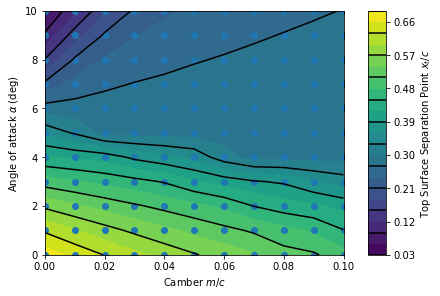

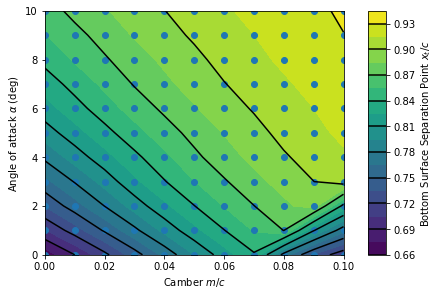

In [132]:
sep_list = np.array(sep_list)
shape = np.shape(sep_list)[:2]

top_x = np.empty(shape)
top_y = np.empty(shape)
bot_x = np.empty(shape)
bot_y = np.empty(shape)

for x in range(np.shape(sep_list)[0]):
    for y in range(np.shape(sep_list)[1]):
        xs, ys = sep_list[x,y]
        x1, x2 = xs
        y1, y2 = ys
        top_x[x, y] = x1
        bot_x[x, y] = x2
        top_y[x, y] = y1
        bot_y[x, y] = y2

fig1, ax2 = plt.subplots(constrained_layout=True)
contour_plot = ax2.contourf(m_c, np.rad2deg(alpha), top_x, 20)
ax2.set_xlabel(r'Camber $m/c$')
ax2.set_ylabel(r'Angle of attack $\alpha$ (deg)')
contour_plot2 = ax2.contour(contour_plot, levels=contour_plot.levels[::2], colors='k', origin='lower')
cbar = fig1.colorbar(contour_plot)
cbar.ax.set_ylabel(r'Top Surface Separation Point $x_t/c$')
cbar.add_lines(contour_plot2)
plt.scatter(test_locs_x, test_locs_y)
ax2.set_xlim(0, max(m_c))
ax2.set_ylim(0, np.rad2deg(max(alpha)))
plt.show()

fig1, ax2 = plt.subplots(constrained_layout=True)
contour_plot = ax2.contourf(m_c, np.rad2deg(alpha), bot_x, 20)
ax2.set_xlabel(r'Camber $m/c$')
ax2.set_ylabel(r'Angle of attack $\alpha$ (deg)')
contour_plot2 = ax2.contour(contour_plot, levels=contour_plot.levels[::2], colors='k', origin='lower')
cbar = fig1.colorbar(contour_plot)
cbar.ax.set_ylabel(r'Bottom Surface Separation Point $x_t/c$')
cbar.add_lines(contour_plot2)
plt.scatter(test_locs_x, test_locs_y)
ax2.set_xlim(0, max(m_c))
ax2.set_ylim(0, np.rad2deg(max(alpha)))
plt.show()

In [89]:
@np.vectorize
def naca4_added_mass(m_c):
    foil = make_naca4(N=N, m=m_c)
    m11, m12, m22, m66 = added_mass(foil)
    return m11, m12, m22, m66

m11_list, m12_list, m22_list, m66_list = naca4_added_mass(m_c)

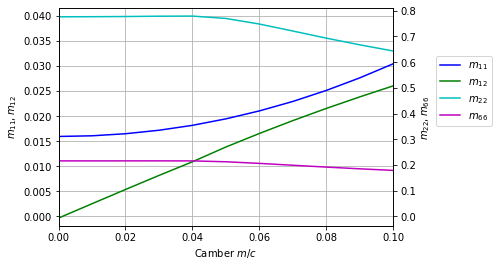

In [90]:
def align_yaxis(ax1, v1, ax2, v2):
    """Align zeros of the two axes, zooming them out by same ratio
    Source: Pietro Battiston, https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin
    """
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]


fig, ax1 = plt.subplots()
ax1.set_ylabel(r'$m_{11}, m_{12}$')
ax1.set_xlabel(r'Camber $m/c$')
ax1.set_xlim(0, max(m_c))

ax1.grid()
ax1.plot(m_c, m11_list, 'b', label='$m_{11}$')
ax1.plot(m_c, m12_list, 'g', label='$m_{12}$')

ax2 = ax1.twinx() 
ax2.set_ylabel(r'$m_{22}, m_{66}$')
ax2.plot(m_c, m22_list, 'c', label='$m_{22}$')
ax2.plot(m_c, m66_list, 'm', label='$m_{66}$')
fig.legend(loc='best', bbox_to_anchor=(1.15, 0.75))
align_yaxis(ax1, 0, ax2, 0)
plt.show()

The same proccess is done for each $m/c$ value for a range of angle of attack. 